# **Modelamiento**

## Librerías

In [ ]:
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 1.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
!pip install unidecode

     |████████████████████████████████| 235 kB 4.2 MB/s 


In [ ]:
#Generales
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Proceso de Modelación
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,median_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, ShuffleSplit

from sklearn.feature_extraction.text import CountVectorizer

## Lectura Información

In [ ]:
#Descargar datasets desde github
!git clone https://github.com/andres-soto-h/monografia-udea-eacd.git

Cloning into 'monografia-udea-eacd'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [ ]:
#Lectura del dataset transformado
df_propiedades=pd.read_csv('/content/monografia-udea-eacd/df_prop_clean_12082021.csv', delimiter=';', encoding='latin1')

In [ ]:
df_propiedades.rename(columns={"municipio":"ubicacion"}, inplace=True)

**NOTA:** se decide eliminar la información del municipio de **La Unión**.

In [ ]:
mask_union = df_propiedades['ubicacion']!='la uniÃ³n'
df_propiedades = df_propiedades[mask_union]

In [ ]:
df_propiedades['ubicacion'].value_counts()

rionegro                  1241
el retiro                  439
la ceja                    342
guarne                     196
marinilla                  117
el carmen de viboral        62
san antonio de pereira      38
llanogrande                 31
santuario                   15
Name: ubicacion, dtype: int64

**Nota2:** Se convierte la variable Estrato en ordinal

In [ ]:
df_propiedades['estrato'] = df_propiedades['estrato'].replace('Campestre', '0')
df_propiedades['estrato'] = df_propiedades['estrato'].astype(int)
df_propiedades['estrato'].value_counts()

4    947
5    636
3    584
0    162
6     89
2     58
1      5
Name: estrato, dtype: int64

## **Ajuste del Modelo**

**Funciones**

In [ ]:
#Métricas datos transformados
def median_absolute_error2(y_true, y_pred):
  return median_absolute_error(np.expm1(y_true), np.expm1(y_pred))

def mean_squared_error2(y_true, y_pred):
  return mean_squared_error(np.expm1(y_true), np.expm1(y_pred), squared=False)


def mean_absolute_percentage_error2(y_true, y_pred):
  return mean_absolute_percentage_error(np.expm1(y_true), np.expm1(y_pred))
  
def r2_score2(y_true, y_pred):
  return r2_score(np.expm1(y_true), np.expm1(y_pred))

In [ ]:
def div_train_test(X, y, var_stratify = ''):
  
  if var_stratify != '': 
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9, stratify = X[var_stratify],  random_state = 42)

    var_stratify_train = x_train[var_stratify]
    #ubicacion_test = X_test['ubicacion']

    x_train.drop(var_stratify,axis=1, inplace=True)
    x_test.drop(var_stratify,axis=1, inplace=True)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)

    return x_train, x_test, y_train, y_test, y_train_t, y_test_t, var_stratify_train

  else:
    x_train, x_test, y_train, y_test = train_test_split(X,y, train_size=0.9,  random_state = 42)

    #Variable Objetivo Transformada
    y_train_t = np.log1p(y_train)
    y_test_t = np.log1p(y_test)
  
  return x_train, x_test, y_train, y_test, y_train_t, y_test_t

def busqueda_hiperparametros(x_train, y_train, var_stratify_train, estimator,param_grid = [] , scoring_med = 'neg_median_absolute_error', transf=False):

  if len(var_stratify_train) != 0:
    
    print('Seccion Stratify')
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
    stratified = sss.split(x_train, var_stratify_train)
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, cv = stratified, scoring = scoring_grid , refit = 'metrica',  return_train_score=True, n_jobs=-1, verbose=8)
    return grid.fit(x_train, y_train)
  
  else:
    print('OutStratify')
    
    if transf: 
      print('**para datos transformados**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error2), 'r2':make_scorer(r2_score2) , 'rmse':make_scorer(mean_squared_error2), 'mape':make_scorer(mean_absolute_percentage_error2)}
    else:
      print('**para datos sin transformar**')
      scoring_grid={'metrica':scoring_med,'meae':make_scorer(median_absolute_error), 'r2':make_scorer(r2_score) , 'rmse':make_scorer(mean_squared_error), 'mape':make_scorer(mean_absolute_percentage_error)}
    
    grid = GridSearchCV(estimator, param_grid=param_grid, scoring = scoring_grid, refit = 'metrica', return_train_score=True, n_jobs=-1, verbose=8 )
    return grid.fit(X_train, y_train)

def metricas(model,y_train, p_train, y_test, p_test): 

  resultados = {
      'parametros' : [model.get_params()['steps'][1][1]],
      'MeAE_train' : [median_absolute_error(y_train,p_train)],
      'MeAE_test'  : [median_absolute_error(y_test, p_test)],
      'MAPE_train' : [mean_absolute_percentage_error(y_train,p_train)],
      'MAPE_test'  : [mean_absolute_percentage_error(y_test, p_test)],
      'r2_train'   : [r2_score(y_train,p_train)],
      'r2_test'    : [r2_score(y_test, p_test)],
      'rmse_train' : [mean_squared_error(y_train,p_train,squared = False)],
      'rmse_test'  : [mean_squared_error(y_test,p_test,squared = False)]
  }
  return pd.DataFrame(resultados)

**División Covariables  y Variable Objetivo**

In [ ]:
data_model=df_propiedades.copy()
varibles_considerar = ['tipo','precio','area_m2','banos','garajes','antiguedad','estrato','ubicacion','tipo_propiedad','balcon','zonas_verdes','en_conjunto_cerrado','zona_infantil','supermercados_ccomerciales','colegios_universidades','trans_publico_cercano']
data_model = data_model.loc[:,varibles_considerar]
data_model.shape

(2481, 16)

In [ ]:
X = data_model.drop(['precio'], axis=1)
y = data_model['precio']

**OneHotEncoder Variables Categóricas**

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
data_aux = pd.DataFrame(enc.fit_transform(X[['tipo','tipo_propiedad','ubicacion','antiguedad']]).toarray(), columns= enc.get_feature_names(['tipo','tipo_propiedad','ubicacion','antiguedad']))
data_aux['fila'] = range(0, X.shape[0])
data_aux.head()

X.drop(['tipo','tipo_propiedad','antiguedad'],axis=1,inplace=True)
X['fila'] = range(0, X.shape[0])

X = pd.merge(data_aux,X, on = 'fila', how='inner')
X.drop(['fila'], axis=1, inplace=True)
X.shape

(2481, 33)

_______________________________________________________________

Información de la columna **Descripción**

In [ ]:
#Descargar stopwords español
!wget https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt

--2021-11-15 13:13:52--  https://raw.githubusercontent.com/Alir3z4/stop-words/master/spanish.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4244 (4.1K) [text/plain]
Saving to: ‘spanish.txt’

spanish.txt         100%[===================>]   4.14K  --.-KB/s    in 0s      

2021-11-15 13:13:52 (49.6 MB/s) - ‘spanish.txt’ saved [4244/4244]



In [ ]:
import re

data_text=pd.DataFrame(df_propiedades["descripcion"])
data_text

#Limpieza básica del texto
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.lower())
data_text['descripcion'] = data_text['descripcion'].apply((lambda x: re.sub(r'[0-9]+','',x)))
#data_text['descripcion'] = data_text['descripcion'].apply((lambda x: re.sub(r'[^\w\s]','',x)))

In [ ]:
#Corregir error de encoding en textos
def replace_char(text):
  fix_text=text.replace('ã¡','a').replace('ã','a').replace('ã³','o').replace('ã±','ñ').replace('ã\x81','a').replace('ãº','u').replace('ã©','e').replace('ã\xad','i').replace('ã\x8d','i')
  return fix_text

data_text['descripcion'] = data_text['descripcion'].apply(replace_char)

In [ ]:
data_text['descripcion'][1]

'venta casa urbanizacia³n jardines del camino      a\x81reaa:  m   estrato:    precio:  millones   mezzaninee de  m      casa de  pisos mas mezzanine,  cuenta con  habitaciones,   baa±os,   parqueaderos cubiertos,  cocina integral en isla y barra estilo americana,  zona de lavandera\xada,  escalera con estructura metalica y escalones en madera.     habitacia³n principal con baa±o privado y vestier,  habitaciones auxiliares con su respectivo closet,  unas habitacia³n ubicada en el primer piso,  baa±os auxiliares.      ubicadaa en un excelente sector recidencial,  con facil acceso a centro comerciales,  gimnasios,  zonas deportivas,  zonas infantiles,  iglesias,  supermercados,  cerca a zona comercial y parque principal.     .'

Estematización o steaming ( realiza con algoritmos más sencillos utiliza el nltk ). Consultar como hacer el steaming con Español. La idea es llevar las palabras a su raiz. 

---



In [ ]:
synopses = data_text['descripcion']

In [ ]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')
synopsesStem = []
for sentence in synopses:
     synopsesStem.append(" ".join([stemmer.stem(word) for word in sentence.split()]))
#define vectorizer parameters
count_vectorizer = CountVectorizer(max_df=1.0, max_features=200,
                                 min_df=0.1)

count_matrix = count_vectorizer.fit_transform(synopsesStem) #fit the vectorizer to synopses
#count_vectorizer.get_feature_names()

In [ ]:
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("alcobas", "alcoba"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("closets", "closet"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplia", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplias", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplio", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("amplios", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("ampliars", "ampliar"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("zonas", "zona"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("apartamentos", "apto"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("apartamento", "apto"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("aptos", "apto"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("mt", "mts"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("metros cuadrados", "mts"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("m2", "mts"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("balcones", "balcon"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("baños", "baño"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("iglesias", "iglesia"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("espacio", "espacios"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("habitaciones", "habitacion"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("espacio", "espacios"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("niveles", "nivel"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("publico", "publicos"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("hermosa", "hermoso"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("hermosas", "hermoso"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("hermosos", "hermoso"))
data_text['descripcion'] = data_text['descripcion'].apply(lambda x: x.replace("ropas", "ropa"))

In [ ]:
data_text['descripcion'][7]

'excelente oportunidad de inversia³n  casa ubicada en san antonio de pereira,  uno de los mejores sitios para vivir en el oriente ant.  tres pisos  sala-comedor,  cocina integral,  star para sala tv,  tres habitacion,  tres baa±os,  balca³n,  garaje,  zona de ropa  cerca al parque principal de san antonio de pereira,  supermercados,  iglesia,  farmacia,  transporte,  cla\xadnica somer,  comfama parque recreativo.  aeropuerto y taºnel de oriente a  minutos. .'

In [ ]:
stopwords = pd.read_csv('spanish.txt', header = None, sep='\n')
stopwords_list = list(stopwords[0])

**División train y Test**

In [ ]:
X_train, X_test, Y_train, Y_test, Y_train_t, Y_test_t, var_stratify_train = div_train_test(X, y, var_stratify = 'ubicacion')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### **Red Neuronal**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN, Embedding, Input
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
from time import time

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [ ]:
X_train_scaled.shape

(2232, 32)

In [ ]:
def build_model(n_units=100 ,n_layers=3, drop_rate=0.1, input_shape = 32):

  model = keras.Sequential()
  model.add(Input(shape=input_shape))

  neuron_list=[]
  neuron_list.append(n_units)

  for n in range(1, n_layers):
    neuron_list.append(neuron_list[n-1]/2)

  for n in neuron_list:
    model.add(Dense(units=n, activation = 'relu'))
    model.add(Dropout(drop_rate))
  
  model.add(Dense(1))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,
      beta_1=0.9,beta_2=0.999, epsilon=1e-07,amsgrad=False,
      name="Adam")

  model.compile(loss='mean_absolute_percentage_error',
                optimizer=optimizer, 
                metrics=['mean_absolute_percentage_error'])
  
  return model

In [ ]:
model=build_model(n_units=217 ,n_layers=2, drop_rate=0.1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 217)               7161      
                                                                 
 dropout (Dropout)           (None, 217)               0         
                                                                 
 dense_1 (Dense)             (None, 108)               23544     
                                                                 
 dropout_1 (Dropout)         (None, 108)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 109       
                                                                 
Total params: 30,814
Trainable params: 30,814
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start=time()

model = KerasRegressor(build_fn=build_model)
neurons = np.array([64, 128, 256, 512])
epochs = 200

param_grid = dict(n_units=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid , cv=2, scoring='neg_mean_absolute_percentage_error')
grid_result = grid.fit(X_train_scaled, Y_train.to_numpy(),batch_size=32, epochs=epochs)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

print("total time:",time()-start)

Epoch 1/200
35/35 [==============================] - 1s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000
Epoch 4/200
35/35 [==============================] - 0s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000
Epoch 5/200
35/35 [==============================] - 0s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000
Epoch 6/200
35/35 [==============================] - 0s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000
Epoch 7/200
35/35 [==============================] - 0s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000
Epoch 8/200
35/35 [==============================] - 0s 2ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000


In [ ]:
import datetime

model=build_model(n_units=512 ,n_layers=3, drop_rate=0.1)

model.fit(X_train_scaled, Y_train.to_numpy(),batch_size=32, epochs=300, validation_data=(X_test_scaled, Y_test.to_numpy()))

Epoch 1/300
70/70 [==============================] - 2s 8ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 2/300
70/70 [==============================] - 0s 5ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 3/300
70/70 [==============================] - 0s 6ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 4/300
70/70 [==============================] - 0s 5ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 5/300
70/70 [==============================] - 0s 5ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 6/300
70/70 [================

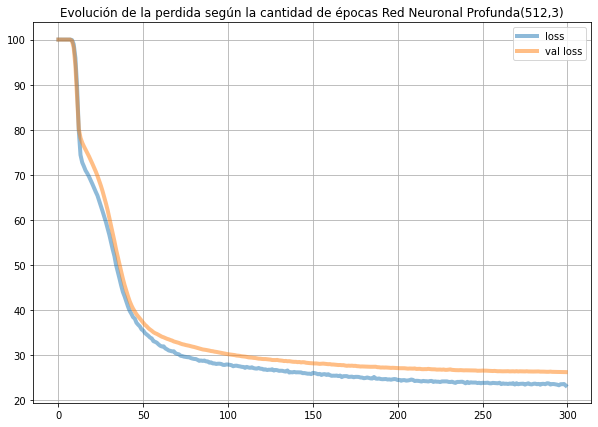

In [ ]:
plt.figure(figsize=(10,7))
loss  = model.history.history["loss"]
vloss = model.history.history["val_loss"]
plt.plot(loss, lw=4, alpha=.5, label="loss")
plt.plot(vloss, lw=4, alpha=.5, label="val loss")
plt.title("Evolución de la perdida según la cantidad de épocas Red Neuronal Profunda(512,3)")
plt.grid();
plt.legend();

## **Segunda Arquitectura**

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing Stop Words

from nltk.corpus import stopwords
all_sentences = data_text['descripcion'].values
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
stop_words = stopwords.words('spanish')
stop_words.append('')

for i in range(len(all_words)):  
    all_words[i] = [w for w in all_words[i] if (w not in stop_words) and (not w.isdigit())]

In [ ]:
max=0
for sentence in all_words:  
  if len(sentence)>max:
    max = len(sentence)

max

142

In [ ]:
def get_preprocessed_seq(text_list):

    import tensorflow as tf
    from tensorflow.keras.preprocessing.text import Tokenizer

    max_features = 500
    tokenizer = Tokenizer(num_words=max_features, split=' ')
    
    tokenizer.fit_on_texts(text_list)
    X = tokenizer.texts_to_sequences(text_list)

    Xdata = tf.keras.preprocessing.sequence.pad_sequences(X, dtype='int32', padding='post', value=0.0)

    return tokenizer, Xdata 


tokenizer, NewX = get_preprocessed_seq(all_words)

NewX_train=NewX[list(X_train.index.to_numpy())]
NewX_test =NewX[list(X_test.index.to_numpy())]

In [ ]:
!pip install --upgrade keras-hypetune

In [ ]:
from kerashypetune import KerasGridSearch
from tensorflow.keras.callbacks import *

In [ ]:
def build_model2(param):

    inp1 = Input(shape=(X_train_scaled.shape[1],), name="Input_Feautures")
    
    neuron_list=[]
    neuron_list.append(param['unit_1'])

    for n in range(1, param['n_layers']):
      neuron_list.append(neuron_list[n-1]/2)

    x = Dense(param['unit_1'], activation="relu", name="dense1")(inp1)

    for idx, n in enumerate(neuron_list[1:]):

      x = Dense(units=n, activation = 'relu', name="Dense_"+str(idx))(x)
      x = Dropout(param['drop_rate'], name="Dropout"+str(idx))(x)

    inp2 = Input(shape=(NewX_train.shape[1],), name="Input_Text")
    cc1 = Embedding(input_dim=(tokenizer.num_words+1), output_dim=32, mask_zero=True)(inp2)
    cc2 = LSTM(param['cells_number'], return_sequences=False)(cc1)

    cc3 = tf.concat([x, cc2],axis=1)
    cc4 = Dense(10, activation='relu', name="Dense_concat")(cc3)
    cc5 = Dropout(param['drop_rate'], name="Dropout_concat")(cc4)
    output = Dense(1, name="Output")(cc5)
    
    model = Model(inputs=[inp1, inp2], outputs=output)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=param['lr'],beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name="Adam")

    model.compile(loss='mean_absolute_percentage_error',optimizer=optimizer, metrics=['mean_absolute_percentage_error'])
  
    return model

In [ ]:
#https://stackoverflow.com/questions/56824968/grid-search-for-keras-with-multiple-inputs/62512554#62512554
start=time()

param_grid = {
    'unit_1': [256, 512], 
    'lr': 0.001, 
    'epochs': 100, 
    'batch_size': [32, 64],
    'n_layers':3, 
    'drop_rate':0.1, 
    'cells_number':10
}

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
hypermodel = build_model2

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=2)
kgs.search([X_train_scaled, NewX_train], Y_train.to_numpy(), validation_data=([X_test_scaled, NewX_test],  Y_test.to_numpy()))


print("total time:",time()-start)


4 trials detected for ('unit_1', 'lr', 'epochs', 'batch_size', 'n_layers', 'drop_rate', 'cells_number')

***** (1/4) *****
Search({'unit_1': 256, 'lr': 0.001, 'epochs': 100, 'batch_size': 32, 'n_layers': 3, 'drop_rate': 0.1, 'cells_number': 10})
SCORE: 28.35471 at epoch 100

***** (2/4) *****
Search({'unit_1': 256, 'lr': 0.001, 'epochs': 100, 'batch_size': 64, 'n_layers': 3, 'drop_rate': 0.1, 'cells_number': 10})
SCORE: 32.00077 at epoch 100

***** (3/4) *****
Search({'unit_1': 512, 'lr': 0.001, 'epochs': 100, 'batch_size': 32, 'n_layers': 3, 'drop_rate': 0.1, 'cells_number': 10})
SCORE: 27.25123 at epoch 100

***** (4/4) *****
Search({'unit_1': 512, 'lr': 0.001, 'epochs': 100, 'batch_size': 64, 'n_layers': 3, 'drop_rate': 0.1, 'cells_number': 10})
SCORE: 28.73308 at epoch 99
total time: 1567.9666912555695


In [ ]:
kgs.best_score

27.25123

In [ ]:
kgs.best_params

{'batch_size': 32,
 'cells_number': 10,
 'drop_rate': 0.1,
 'epochs': 100,
 'lr': 0.001,
 'n_layers': 3,
 'steps_per_epoch': 70,
 'unit_1': 512}

In [ ]:
# Input es la longitud de la secuencia que va a ingresar (longitud de los textos)
# Hacer análisis de la longitud de los textos para ver la cantidad de palabras que tiene cada descripción
# El embedding tiene todas las posibles palabras mientras que en el input llegan todas las palabras de la frase
# Probar removiendo stopwords y sin quitarlos 
# Si LSTM no es la primera no es necesario ponerle el shape
# train test split puede recibir varias matrices y las retorna divididas

# Todos los ajustes en función de costo realizado en el modelo simple, deben repetirse en este modelo
# búsqueda de hiperparametros para las dos arquitecturas

In [ ]:
param_grid = {
    'unit_1': 512, 
    'lr': 0.001, 
    'epochs': 100, 
    'batch_size': 32,
    'n_layers':3, 
    'drop_rate':0.1, 
    'cells_number':10
}

model2 = build_model2(param_grid)
model2.summary()

Model: "model_47"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Feautures (InputLayer)   [(None, 32)]         0           []                               
                                                                                                  
 dense1 (Dense)                 (None, 512)          16896       ['Input_Feautures[0][0]']        
                                                                                                  
 Dense_0 (Dense)                (None, 256)          131328      ['dense1[0][0]']                 
                                                                                                  
 Dropout0 (Dropout)             (None, 256)          0           ['Dense_0[0][0]']                
                                                                                           

In [ ]:
model2.fit([X_train_scaled, NewX_train], Y_train.to_numpy(),batch_size=32, epochs=300, validation_data=([X_test_scaled, NewX_test], Y_test.to_numpy()))

Epoch 1/300
70/70 [==============================] - 11s 97ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 2/300
70/70 [==============================] - 5s 76ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 3/300
70/70 [==============================] - 5s 78ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 4/300
70/70 [==============================] - 5s 78ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 5/300
70/70 [==============================] - 5s 77ms/step - loss: 100.0000 - mean_absolute_percentage_error: 100.0000 - val_loss: 100.0000 - val_mean_absolute_percentage_error: 100.0000
Epoch 6/300
70/70 [==========

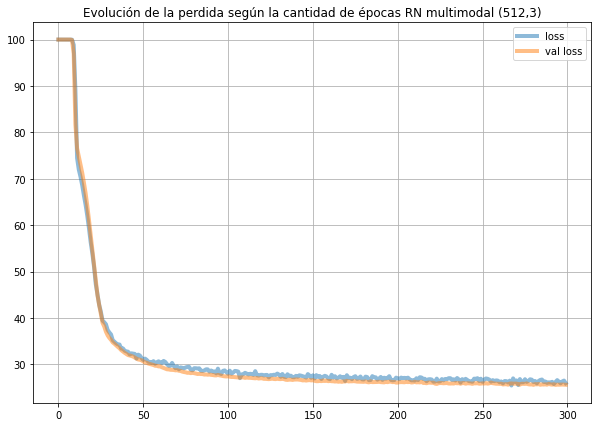

In [ ]:
plt.figure(figsize=(10,7))
loss2  = model2.history.history["loss"]
vloss2 = model2.history.history["val_loss"]
plt.plot(loss2, lw=4, alpha=.5, label="loss")
plt.plot(vloss2, lw=4, alpha=.5, label="val loss")
plt.title("Evolución de la perdida según la cantidad de épocas RN multimodal (512,3)")
plt.grid();
plt.legend();

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive/')
# %cd '/content/drive/My Drive/Colab Notebooks/Seminario/Etapa Modelamiento/Resultados'